# Regression

*Supervised* machine learning techniques involve training a model to operate on a set of *features* and predict a *label* using a dataset that includes some already-known label values. The training process *fits* the features to the known labels to define a general function that can be applied to new features for which the labels are unknown, and predict them. You can think of this function like this, in which ***y*** represents the label we want to predict and ***x*** represents the features the model uses to predict it.

$$y = f(x)$$

In most cases, *x* is actually a *vector* that consists of multiple feature values, so to be a little more precise, the function could be expressed like this:

$$y = f([x_1, x_2, x_3, ...])$$

The goal of training the model is to find a function that performs some kind of calculation to the *x* values that produces the result *y*. We do this by applying a machine learning *algorithm* that tries to fit the *x* values to a calculation that produces *y* reasonably accurately for all of the cases in the training dataset.

In this notebook, we'll focus on *regression*, using an example based on a real study in which data for a bicycle sharing scheme was collected and used to predict the number of bike share counts based on seasonality and weather conditions.


## Explore the Data

The first step in any machine learning project is to explore the data that you will use to train a model. The goal of this exploration is to try to understand the relationships between its attributes; in particular, any apparent correlation between the *features* and the *label* your model will try to predict. This may require some work to detect and fix issues in the data (such as dealing with missing values, errors, or outlier values), deriving new feature columns by transforming or combining existing features (a process known as *feature engineering*), *normalizing* numeric features (values you can measure or count) so they're on a similar scale, and *encoding* categorical features (values that represent discrete categories) as numeric indicators.

Let's start by loading the bicycle sharing data as a **Pandas** DataFrame and viewing the first few rows.

In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('./vds16.csv')
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84
2,2017-04-02 0:10,46,34,12,0,50.6,1.87
3,2017-04-02 0:15,45,36,9,0,50.9,1.72
4,2017-04-02 0:20,27,13,13,1,62.2,1.12


The data consists of the following columns:

- **timestamp**: Representing timestamp of bike share
- **cnt**: Representing total number of bike shares
- **t1**: The temperature in celsius.
- **t2**: The apparent ("feels-like") temperature in celsius.
- **hum**: The humidity level
- **wind_speed**: The windspeed
- **weather_code**: A categorical value indicating the weather situation (1:clear, 2:mist/cloud, 3:light rain/snow, 4:heavy rain/hail/snow/fog)
- **is_holiday**: A binary value indicating whether or not the day is a holiday
- **is_weekend**: A binary value indicating whether or not the day is a weekend
- **season**: A numerically encoded value indicating the season (1:spring, 2:summer, 3:fall, 4:winter)


In this dataset, **cnt** represents the label (the *y* value) our model must be trained to predict. The other columns are potential features (*x* values).

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8064 entries, 0 to 8063
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      8064 non-null   object 
 1   ToVol     8064 non-null   int64  
 2   SmVol     8064 non-null   int64  
 3   MeVol     8064 non-null   int64  
 4   LaVol     8064 non-null   int64  
 5   Speed     8064 non-null   float64
 6   Occ.Rate  8064 non-null   float64
dtypes: float64(2), int64(4), object(1)
memory usage: 441.1+ KB


From the above results it is evident that there are no null values and total 17413 records in the dataset

## Feature Engineering
We can perform some *feature engineering* to combine or derive new features. For example, let's add new columns named **day**, **month**, **hour** to the dataframe by extracting the day component from the existing **timestamp** column.

In [9]:
# as the datatype of timestamp is object we need to convert it into datetime
df["Date"] = pd.to_datetime(df["Date"])
df["month"] = df["Date"].apply(lambda x:x.month)
df["day"] = df["Date"].apply(lambda x:x.day)
df["hour"] = df["Date"].apply(lambda x:x.hour)
df = df.drop("Date", axis=1) 

In [10]:
df.head(13)

,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate,month,day,hour
0,43,34,9,0,50.3,1.90,4,2,0
1,45,32,13,0,58.9,1.84,4,2,0
2,46,34,12,0,50.6,1.87,4,2,0
3,45,36,9,0,50.9,1.72,4,2,0
4,27,13,13,1,62.2,1.12,4,2,0
5,30,15,15,0,63.5,1.17,4,2,0
6,27,14,12,1,73.6,0.99,4,2,0
7,40,25,15,0,52.7,1.76,4,2,0
8,31,18,13,0,59.9,1.24,4,2,0
9,38,28,10,0,59.1,1.49,4,2,0


In [11]:
#checking unique values in each column
{column: len(df[column].unique()) for column in df.columns}

{'ToVol': 290,
 'SmVol': 225,
 'MeVol': 105,
 'LaVol': 16,
 'Speed': 518,
 'Occ.Rate': 1635,
 'month': 1,
 'day': 28,
 'hour': 24}

OK, let's start our analysis of the data by examining a few key descriptive statistics. We can use the dataframe's **describe** method to generate these for the numeric features as well as the **cnt** label column.

In [12]:
df.columns

Index(['ToVol', 'SmVol', 'MeVol', 'LaVol', 'Speed', 'Occ.Rate', 'month', 'day',
       'hour'],
      dtype='object')

In [13]:
numeric_features = ['ToVol','SmVol', 'MeVol', 'LaVol', 'Occ.Rate', 'month', 'day', 'hour']
df[numeric_features + ['Speed']].describe()

,ToVol,SmVol,MeVol,LaVol,Occ.Rate,month,day,hour,Speed
count,8064.000000,8064.000000,8064.000000,8064.000000,8064.000000,8064.0,8064.000000,8064.000000,8064.000000
mean,110.459945,79.353299,29.948537,1.158110,6.166941,4.0,15.500000,11.500000,49.327431
std,63.954451,46.802106,19.081136,1.530192,6.739946,0.0,8.078248,6.922616,7.921856
min,6.000000,2.000000,0.000000,0.000000,0.230000,4.0,2.000000,0.000000,9.100000
25%,50.000000,35.000000,13.000000,0.000000,2.140000,4.0,8.750000,5.750000,44.900000
50%,122.000000,87.000000,29.000000,1.000000,5.550000,4.0,15.500000,11.500000,48.500000
75%,155.000000,111.000000,44.000000,2.000000,7.290000,4.0,22.250000,17.250000,54.200000
max,338.000000,250.000000,145.000000,16.000000,82.100000,4.0,29.000000,23.000000,87.800000


In [14]:
df.head(3)

,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate,month,day,hour
0,43,34,9,0,50.3,1.90,4,2,0
1,45,32,13,0,58.9,1.84,4,2,0
2,46,34,12,0,50.6,1.87,4,2,0


he statistics reveal some information about the distribution of the data in each of the numeric fields, including the number of observations (there are 731 records), the mean, standard deviation, minimum and maximum values, and the quartile values (the threshold values for 25%, 50% - which is also the median, and 75% of the data). From this, we can see that the mean number of daily bike share count is around 1143; there's a slight difference in standard deviation, indicating a slight variance in the number of bike shares per day.

We might get a clearer idea of the distribution of bike share values by visualizing the data. Common plot types for visualizing numeric data distributions are *histograms* and *box plots*, so let's use Python's **matplotlib** library to create one of each of these for the **cnt** column.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# This ensures plots are displayed inline in the Jupyter notebook
%matplotlib inline

C:\Users\admin\AppData\Local\Temp\ipykernel_35792\186287850.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


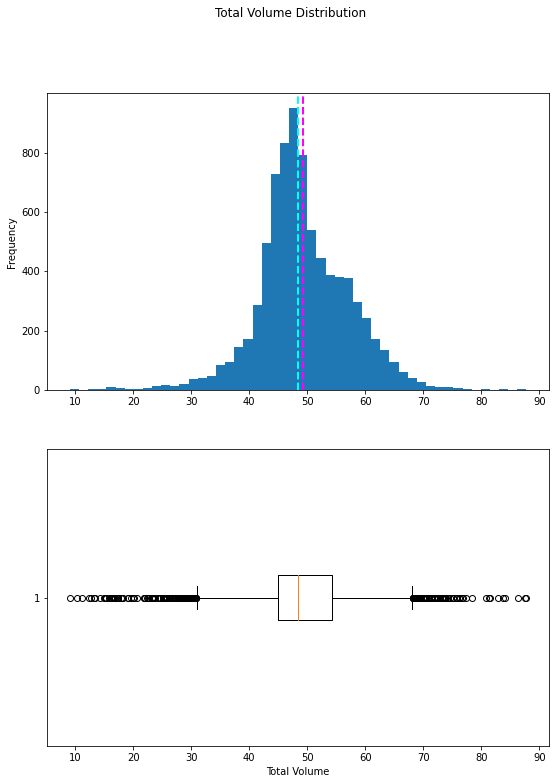

In [16]:
# Get the label column
label = df['Speed']

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=50)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Total Volume')

# Add a title to the Figure
fig.suptitle('Total Volume Distribution')

# Show the figure
fig.show()

The plots show that the number of daily rentals ranges from 0 to just over 5000. However, the mean (and median) number of daily rentals is closer to the low end of that range, with most of the data between 0 and around 1800 bike shares. The few values above this are shown in the box plot as small circles, indicating that they are **outliers** - in other words, unusually high or low values beyond the typical range of most of the data.

We can do the same kind of visual exploration of the numeric features. Let's create a histogram for each of these.

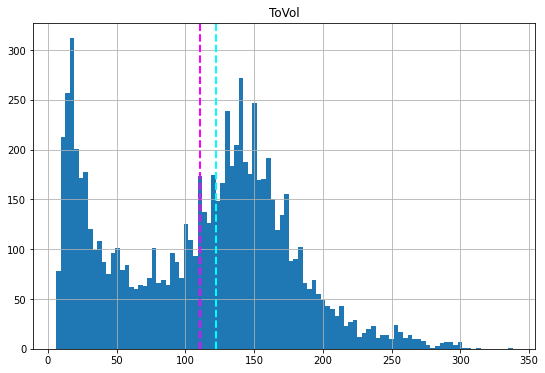

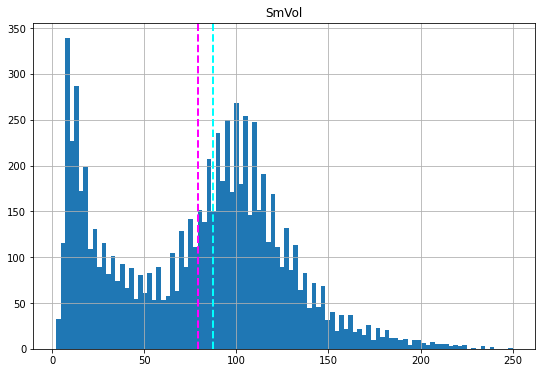

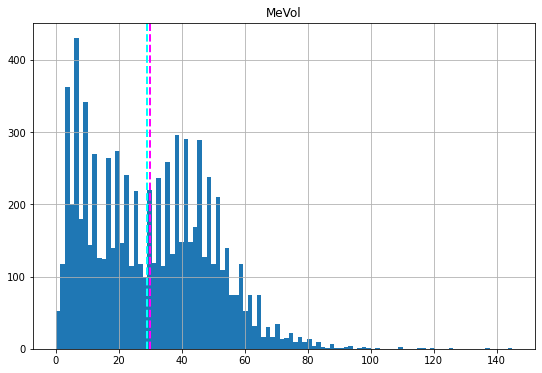

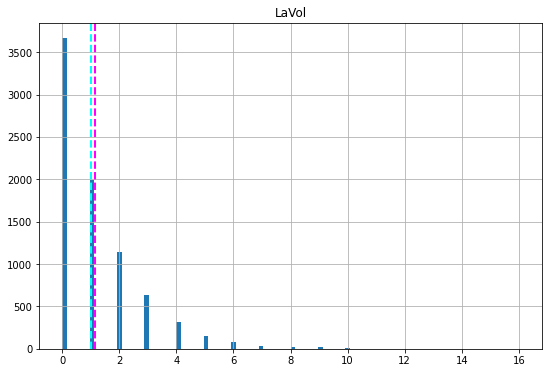

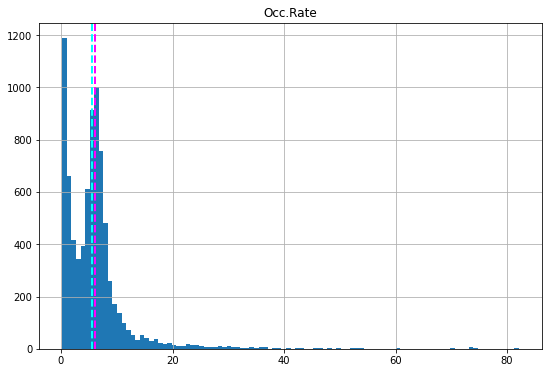

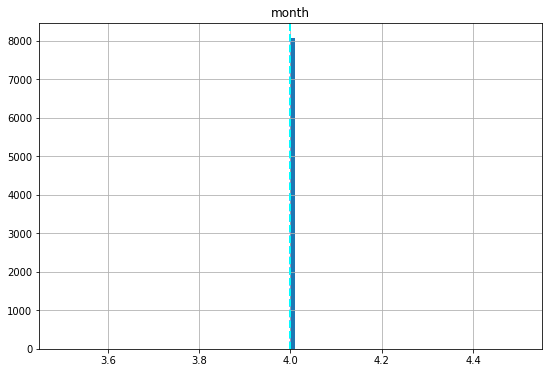

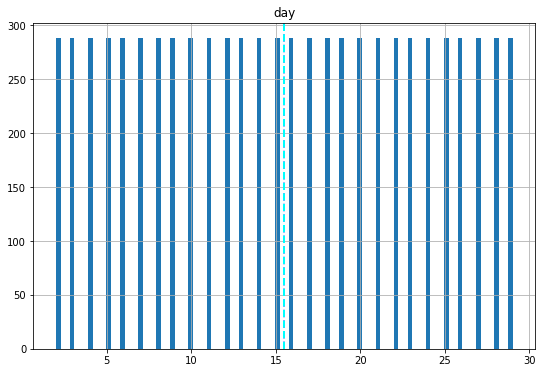

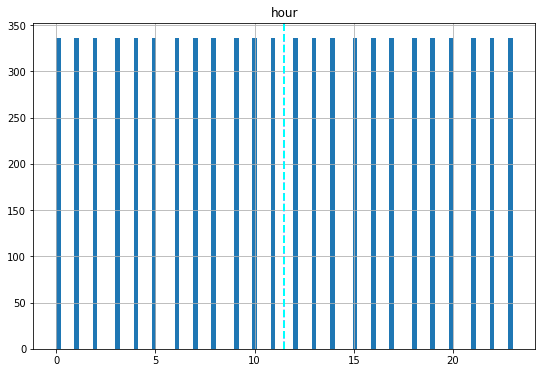

In [17]:
# Plot a histogram for each numeric feature
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    feature.hist(bins=100, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

he numeric features seem to be more *normally* distributed, with the mean and median nearer the middle of the range of values except humidity where mean and median is towards right side, coinciding with where the most commonly occurring values are.

> **Note**: The distributions are not truly *normal* in the statistical sense, which would result in a smooth, symmetric "bell-curve" histogram with the mean and mode (the most common value) in the center; but they do generally indicate that most of the observations have a value somewhere near the middle.

For the numeric features, we can create scatter plots that show the intersection of feature and label values. We can also calculate the *correlation* statistic to quantify the apparent relationship.

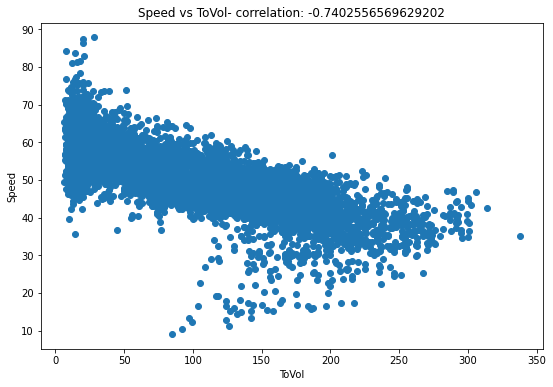

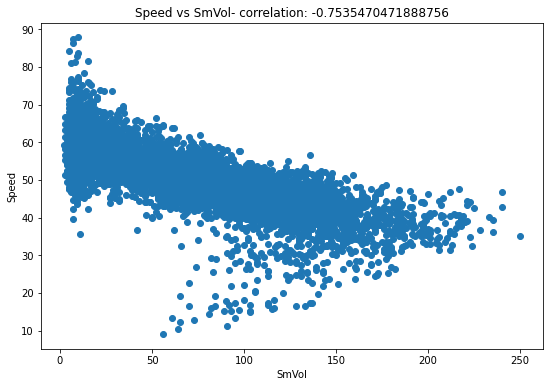

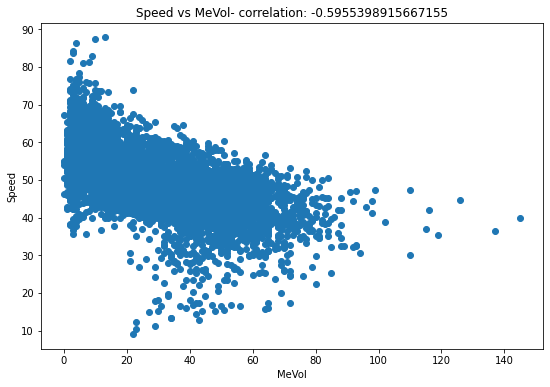

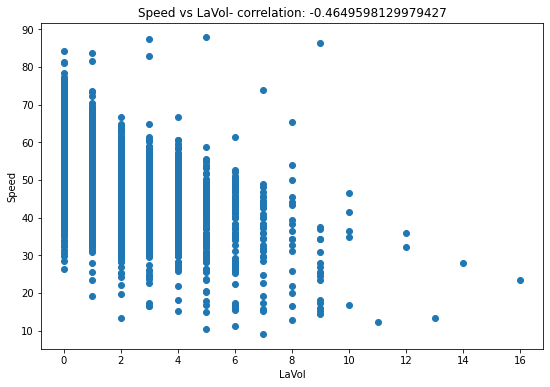

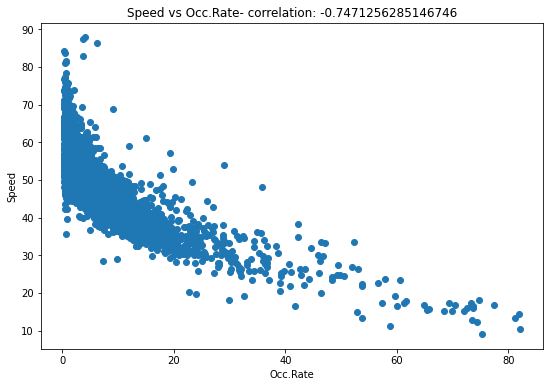

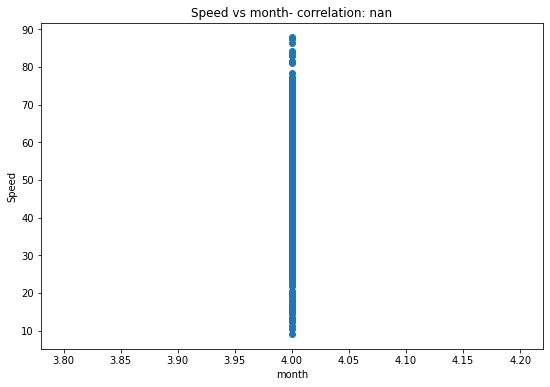

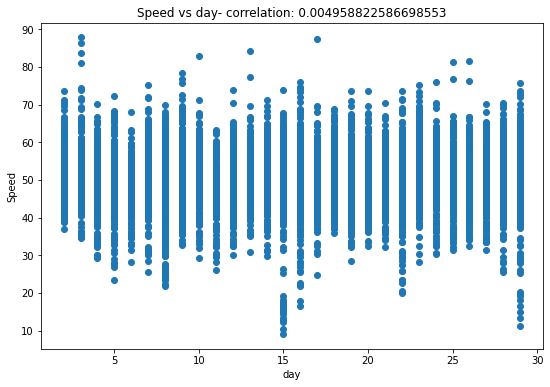

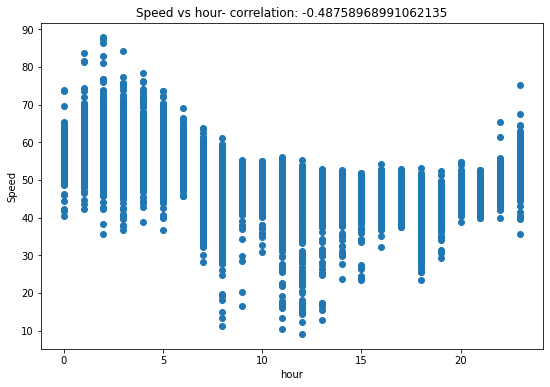

In [20]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    label = df['Speed']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Speed')
    ax.set_title('Speed vs ' + col + '- correlation: ' + str(correlation))
plt.show()


The results aren't conclusive, but if you look closely at the scatter plots for **t1** and **t2**, you can see a vague diagonal trend showing that higher Bike share counts tend to coincide with higher temperatures; and a correlation value of just over 0.5 for both of these features supports this observation. Conversely, the plots for **hum** and **windspeed** show a slightly negative correlation, indicating that there are fewer rentals on days with high humidity or windspeed.

Now let's compare the categorical features to the label. We'll do this by creating box plots that show the distribution of share counts for each category.

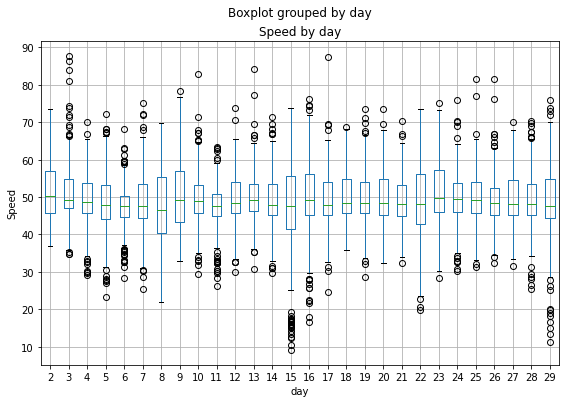

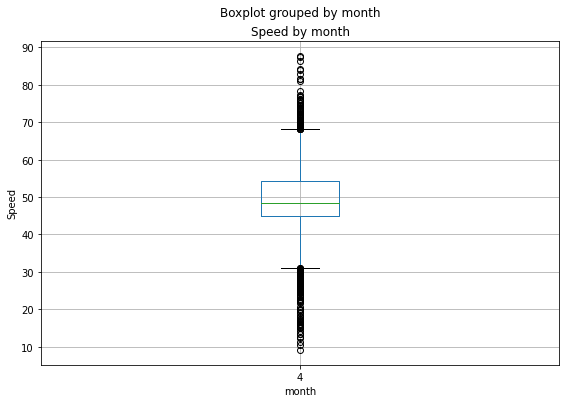

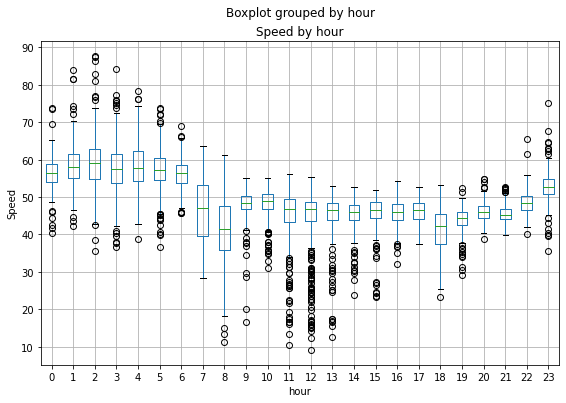

In [21]:
# plot a bar plot for each categorical feature count
categorical_features = ['day','month','hour']
# plot a boxplot for the label by each categorical feature
for col in categorical_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    df.boxplot(column = 'Speed', by = col, ax = ax)
    ax.set_title('Speed by ' + col)
    ax.set_ylabel("Speed")
plt.show()

The plots show some variance in the relationship between some category values and rentals. For example, there's a similar distribution of bike shares on weekends and those during the holiday. There's a noticeable trend that shows different bike share distributions in day time from 10 to 15 compared to evening and night time. 

## Train a Regression Model

Now that we've explored the data, it's time to use it to train a regression model that uses the features we've identified as potentially predictive to predict the **cnt** label.  The first thing we need to do is to separate the features we want to use to train the model from the label we want it to predict.

In [22]:
df.head()

,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate,month,day,hour
0,43,34,9,0,50.3,1.90,4,2,0
1,45,32,13,0,58.9,1.84,4,2,0
2,46,34,12,0,50.6,1.87,4,2,0
3,45,36,9,0,50.9,1.72,4,2,0
4,27,13,13,1,62.2,1.12,4,2,0


In [23]:
# Splitting & scaling the data

X = df.drop("Speed", axis=1)
y = df["Speed"]

print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')

Features:
   ToVol  SmVol  MeVol  LaVol  Occ.Rate  month  day  hour
0     43     34      9      0      1.90      4    2     0
1     45     32     13      0      1.84      4    2     0
2     46     34     12      0      1.87      4    2     0
3     45     36      9      0      1.72      4    2     0
4     27     13     13      1      1.12      4    2     0
5     30     15     15      0      1.17      4    2     0
6     27     14     12      1      0.99      4    2     0
7     40     25     15      0      1.76      4    2     0
8     31     18     13      0      1.24      4    2     0
9     38     28     10      0      1.49      4    2     0

Labels:
0    50.3
1    58.9
2    50.6
3    50.9
4    62.2
5    63.5
6    73.6
7    52.7
8    59.9
9    59.1
Name: Speed, dtype: float64


In [24]:
X.head()

,ToVol,SmVol,MeVol,LaVol,Occ.Rate,month,day,hour
0,43,34,9,0,1.90,4,2,0
1,45,32,13,0,1.84,4,2,0
2,46,34,12,0,1.87,4,2,0
3,45,36,9,0,1.72,4,2,0
4,27,13,13,1,1.12,4,2,0


In [25]:
y.head()

0    50.3
1    58.9
2    50.6
3    50.9
4    62.2
Name: Speed, dtype: float64

After separating the dataset, we now have numpy arrays named **X** containing the features, and **y** containing the labels.

We *could* train a model using all of the data; but it's common practice in supervised learning to split the data into two subsets; a (typically larger) set with which to train the model, and a smaller "hold-back" set with which to validate the trained model. This enables us to evaluate how well the model performs when used with the validation dataset by comparing the predicted labels to the known labels. It's important to split the data *randomly* (rather than say, taking the first 80% of the data for training and keeping the rest for validation). This helps ensure that the two subsets of data are statistically comparable (so we validate the model with data that has a similar statistical distribution to the data on which it was trained).

To randomly split the data, we'll use the **train_test_split** function in the **scikit-learn** library. This library is one of the most widely used machine learning packages for Python.

In [26]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 6451 rows
Test Set: 1613 rows


In [27]:
y_test.shape

(1613,)

Now we have the following four datasets:

- **X_train**: The feature values we'll use to train the model
- **y_train**: The corresponding labels we'll use to train the model
- **X_test**: The feature values we'll use to validate the model
- **y_test**: The corresponding labels we'll use to validate the model

Now we're ready to train a model by fitting a suitable regression algorithm to the training data. We'll use a *linear regression* algorithm, a common starting point for regression that works by trying to find a linear relationship between the *X* values and the *y* label. The resulting model is a function that conceptually defines a line where every possible X and y value combination intersect.

## Feature Scaling
Scaling is a technique often applied as part of data preparation for machine learning. The goal of scaling is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. For standardization we will use standrad scaler. Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

In [30]:
X_train.columns

Index(['ToVol', 'SmVol', 'MeVol', 'LaVol', 'Occ.Rate', 'month', 'day', 'hour'], dtype='object')

In [32]:
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()

features = ['ToVol','SmVol', 'MeVol', 'LaVol', 'Occ.Rate', 'month', 'day', 'hour']
X_train[features ] = scaler.fit_transform(X_train[features ])
X_test[features ] = scaler.transform(X_test[features ])

In [33]:
# Train the model
from sklearn.linear_model import LinearRegression

# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
print (model)

LinearRegression()


## Evaluate Trained Model
Now that we've trained the model, we can use it to predict bike share counts for the features we held back in our validation dataset. Then we can compare these predictions to the actual label values to evaluate how well (or not!) the model is working.

In [34]:
import numpy as np

predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

Predicted labels:  [50. 47. 52. 44. 48. 59. 45. 46. 35. 48.]
Actual labels   :  4574    48.8
7112    48.9
276     47.2
5416    46.2
7157    43.2
629     52.8
2243    45.5
3615    47.9
1255    32.6
5013    48.4
Name: Speed, dtype: float64


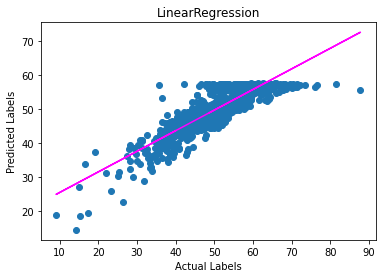

In [50]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('LinearRegression')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

There's a definite diagonal trend, and the intersections of the predicted and actual values are generally following the path of the trend line; but there's a fair amount of difference between the ideal function represented by the line and the results. This variance represents the *residuals* of the model - in other words, the difference between the label predicted when the model applies the coefficients it learned during training to the validation data, and the actual value of the validation label. These residuals when evaluated from the validation data indicate the expected level of *error* when the model is used with new data for which the label is unknown.

You can quantify the residuals by calculating a number of commonly used evaluation metrics. We'll focus on the following three:

- **Mean Square Error (MSE)**: The mean of the squared differences between predicted and actual values. This yields a relative metric in which the smaller the value, the better the fit of the model
- **Root Mean Square Error (RMSE)**: The square root of the MSE. This yields an absolute metric in the same unit as the label (in this case, numbers of rentals). The smaller the value, the better the model (in a simplistic sense, it represents the average number of rentals by which the predictions are wrong!)
- **Coefficient of Determination (usually known as *R-squared* or R<sup>2</sup>)**: A relative metric in which the higher the value, the better the fit of the model. In essence, this metric represents how much of the variance between predicted and actual label values the model is able to explain.

> **Note**: You can find out more about these and other metrics for evaluating regression models in the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

Let's use Scikit-Learn to calculate these metrics for our model, based on the predictions it generated for the validation data.

In [36]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 15.737121308870732
RMSE: 3.967004072202439
R2: 0.7480446943674126


So now we've quantified the ability of our model to predict the number of rentals. It definitely has *some* predictive power, but we can probably do better!

## Experiment with Algorithms

The linear regression algorithm we used to train the model has some predictive capability, but there are many kinds of regression algorithm we could try, including:

- **Linear algorithms**: Not just the Linear Regression algorithm we used above (which is technically an *Ordinary Least Squares* algorithm), but other variants such as *Lasso* and *Ridge*.
- **Tree-based algorithms**: Algorithms that build a decision tree to reach a prediction.
- **Ensemble algorithms**: Algorithms that combine the outputs of multiple base algorithms to improve generalizability.

> **Note**: For a full list of Scikit-Learn estimators that encapsulate algorithms for supervised machine learning, see the [Scikit-Learn documentation](https://scikit-learn.org/stable/supervised_learning.html). There are many algorithms to choose from, but for most real-world scenarios, the [Scikit-Learn estimator cheat sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) can help you find a suitable starting point. 

### Try Another Linear Algorithm

Let's try training our regression model by using a **Lasso** algorithm. We can do this by just changing the estimator in the training code.

Lasso() 

MSE: 17.591824376576923
RMSE: 4.194260885612258
R2: 0.7183504276009613


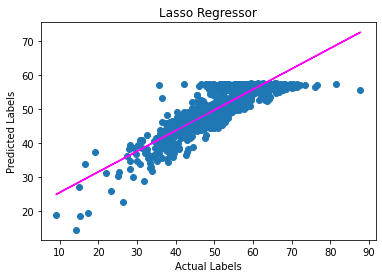

In [49]:
from sklearn.linear_model import Lasso

# Fit a lasso model on the training set
model = Lasso().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Lasso Regressor' )
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

### Try a Decision Tree Algorithm

As an alternative to a linear model, there's a category of algorithms for machine learning that uses a tree-based approach in which the features in the dataset are examined in a series of evaluations, each of which results in a *branch* in a *decision tree* based on the feature value. At the end of each series of branches are leaf-nodes with the predicted label value based on the feature values.

It's easiest to see how this works with an example. Let's train a Decision Tree regression model using the bike rental data. After training the model, the code below will print the model definition and a text representation of the tree it uses to predict label values.

DecisionTreeRegressor() 

MSE: 21.277427154370738
RMSE: 4.612746161926834
R2: 0.6593429918639111


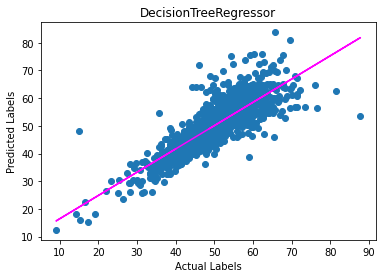

In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

# Train the model
model = DecisionTreeRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('DecisionTreeRegressor')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

So now we have a tree-based model; but is it any good? Let's evaluate it with the test data.

MSE: 19.94380037197768
RMSE: 4.46584822536298
R2: 0.680694695073331


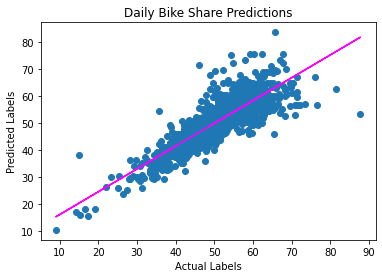

Perfect now our R2 score is more than 90% which means our model has higher predictive power.

### Try an Ensemble Algorithm

Ensemble algorithms work by combining multiple base estimators to produce an optimal model, either by applying an aggregate function to a collection of base models (sometimes referred to a *bagging*) or by building a sequence of models that build on one another to improve predictive performance (referred to as *boosting*).

For example, let's try a Random Forest model, which applies an averaging function to multiple Decision Tree models for a better overall model.

RandomForestRegressor() 

MSE: 11.77878820336553
RMSE: 3.4320239223183644
R2: 0.8114186118596148


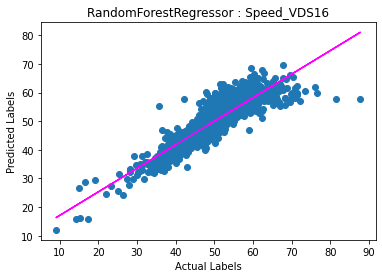

In [45]:
from sklearn.ensemble import RandomForestRegressor

# Train the model
model_rf = RandomForestRegressor().fit(X_train, y_train)
print (model_rf, "\n")

# Evaluate the model using the test data
predictions = model_rf.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('RandomForestRegressor : Speed_VDS16')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

So, this is more accurate than decision tree having R2 score more than 95% and MSE RMSE are also quite lower than decision tree algorithm

For good measure, let's also try a *boosting* ensemble algorithm. We'll use a Gradient Boosting estimator, which like a Random Forest algorithm builds multiple trees, but instead of building them all independently and taking the average result, each tree is built on the outputs of the previous one in an attempt to incrementally reduce the *loss* (error) in the model.

GradientBoostingRegressor() 

MSE: 12.508833784236902
RMSE: 3.53678297103977
R2: 0.7997303968523071


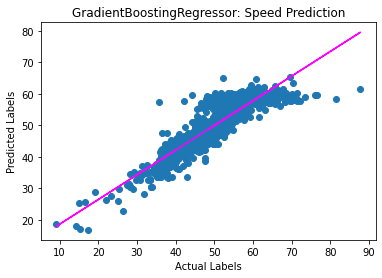

In [46]:
# Train the model
from sklearn.ensemble import GradientBoostingRegressor

# Fit a lasso model on the training set
model = GradientBoostingRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('GradientBoostingRegressor: Speed Prediction')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## LSTM을 적용해보자